RNN ile ayni parametrelerle train et

In [4]:
import h5py as h5
import numpy as np
from matplotlib import pyplot as plt

In [5]:
# Import datasets
f = h5.File("assign3_data3.h5", "r")

# Convert them to np array
trainX = np.array(f['trX'])
testX = np.array(f['tstX'])
trainY = np.array(f['trY'])
testY = np.array(f['tstY'])
f.close()

train_sample = np.random.choice(3000, 2700, replace=False)
train_sample = train_sample.reshape((train_sample.shape[0]))
validation_sample = np.array(list(set(range(3000)) - set(train_sample.reshape((2700)))))
X_train = trainX.reshape((trainX.shape[0], trainX.shape[2], trainX.shape[1]))[train_sample]
X_val = trainX.reshape((trainX.shape[0], trainX.shape[2], trainX.shape[1]))[validation_sample]
y_train = trainY[train_sample]
y_val = trainY[validation_sample]
X_test = testX.reshape((testX.shape[0], testX.shape[2], testX.shape[1]))
y_test = testY
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape
#X_train = X_train/4
#X_val = X_val/4
#X_test = X_test/4

((2700, 3, 150), (2700, 6), (300, 3, 150), (300, 6), (600, 3, 150), (600, 6))

In [6]:
X_train.shape

(2700, 3, 150)

In [7]:
def sigmoid(X):
    return 1 / (1 + np.exp(-1 * X))

def sigmoid_backward(X):
    return np.multiply(X, 1 - X)

def softmax(Z):
    e = np.exp(Z)
    row_sum = np.sum(e, axis=1).reshape((e.shape[0], 1))
    return e / row_sum

def RELU(X):
    return np.multiply(X, X > 0)

def RELU_backward(X):
    return 1*(X > 0)

def tanh(X):
    return ( np.exp(2*X) - 1 ) / ( np.exp(2 * X) + 1)

def tanh_backward(X):
    return 1 - X**2

def unison_shuffled_copies(a, b):
    assert a.shape[0] == b.shape[0]
    p = np.random.permutation(a.shape[0])
    return a[p], b[p]

def initialize_weights(in_size, hid_state_size, hid_layer_size, out_size):
    #https://stackoverflow.com/questions/44883861/initial-bias-values-for-a-neural-network
    W = {}
    U = {}
    b = {}
    
    t_x = (6/(in_size+hid_state_size))**(1/2)
    t_h = (3/hid_state_size)**(1/2)
    W['c'] = np.random.uniform(low=-1*t_h, high=t_h, size=(hid_state_size, hid_state_size))
    U['c'] = np.random.uniform(low=-1*t_x, high=t_x, size=(in_size, hid_state_size))
    b['c'] = np.zeros((1, hid_state_size))
    W['i'] = np.random.uniform(low=-1*t_h, high=t_h, size=(hid_state_size, hid_state_size))
    U['i'] = np.random.uniform(low=-1*t_x, high=t_x, size=(in_size, hid_state_size))
    b['i'] = np.zeros((1, hid_state_size))
    W['f'] = np.random.uniform(low=-1*t_h, high=t_h, size=(hid_state_size, hid_state_size))
    U['f'] = np.random.uniform(low=-1*t_x, high=t_x, size=(in_size, hid_state_size))
    b['f'] = np.zeros((1, hid_state_size))
    W['o'] = np.random.uniform(low=-1*t_h, high=t_h, size=(hid_state_size, hid_state_size))
    U['o'] = np.random.uniform(low=-1*t_x, high=t_x, size=(in_size, hid_state_size))
    b['o'] = np.zeros((1, hid_state_size))
    
    t = (6/(hid_state_size + hid_layer_size))**(1/2)
    W['1'] = np.random.uniform(low=-1*t, high=t, size=(hid_state_size, hid_layer_size))
    b['1'] = np.zeros((1, hid_layer_size))

    t = (6/(hid_layer_size + out_size))**(1/2)
    W['2'] = np.random.uniform(low=-1*t, high=t, size=(hid_layer_size, out_size))
    b['2'] = np.zeros((1, out_size))
    
    return W, U, b

def predict(X_test, y_test, T, h_init, c_init, W, U, b): # Counts true if the true word is in the top ten predictions
    H, C, I, F, O, C_, hidden, outputs = forward(X_test, h_init, c_init, W, U, b, T)
    correct = np.argmax(y_test, axis=1)
    predictions = np.argmax(outputs, axis=1)
    return np.sum(correct == predictions) / y_test.shape[0]

def calculate_errors(o, d):
    target_predictions = np.multiply(o, d) # Only target class probs
    target_predictions = np.sum(target_predictions, axis=1) 
    return -1 * np.sum(np.log(target_predictions)) # -yi.log(pi)

In [8]:
def cell_forward(h_t_1, C_t_1, x_t, W, U, b):
    i_t = sigmoid(x_t.dot(U['i']) + h_t_1.dot(W['i']) + b['i'])
    f_t = sigmoid(x_t.dot(U['f']) + h_t_1.dot(W['f']) + b['f'])
    o_t = sigmoid(x_t.dot(U['o']) + h_t_1.dot(W['o']) + b['o'])
    C_t_tilda = tanh(x_t.dot(U['c']) + h_t_1.dot(W['c']) + b['c'])
    C_t = sigmoid(np.multiply(f_t, C_t_1) + np.multiply(i_t, C_t_tilda))
    h_t = np.multiply(tanh(C_t), o_t)
    
    return h_t, C_t, i_t, f_t, o_t, C_t_tilda

def forward(x, h_init, c_init, W, U, b, T):
    shape = (x.shape[0], h_init.shape[1], T)
    H = np.zeros(shape)
    C = np.zeros(shape)
    C_tilda = np.zeros(shape)
    I = np.zeros(shape)
    F = np.zeros(shape)
    O = np.zeros(shape)
    
    cur_h = h_init
    cur_c = c_init
    
    for t in range(T):
        cur_h, cur_c, cur_i, cur_f, cur_o, cur_C_tilda = cell_forward(cur_h, cur_c, x[:, :, t], W, U, b)
        #print('cur_h', t, np.mean(cur_h))
        #print('cur_c', t, np.mean(cur_c))
        H[:,:,t] = cur_h
        C[:,:,t] = cur_c
        I[:,:,t] = cur_i
        F[:,:,t] = cur_f
        O[:,:,t] = cur_o
        C_tilda[:,:,t] = cur_C_tilda
    
    #print('w', W['1'][0])
    hidden = RELU(cur_h.dot(W['1']) + b['1'])
    #print('hidden',np.mean(hidden))
    out = softmax(hidden.dot(W['2']) + b['2'])
    #print('out:', np.mean(out))
    return H, C, I, F, O, C_tilda, hidden, out

def cell_backward(delta_h_t, h_t_1, delta_C_t, C_t_1, C_t, i_t, f_t, o_t, C_t_, x_t, W, U, b):
    U_grad = {}
    W_grad = {}
    b_grad = {}
    
    e = np.multiply(tanh(C_t), delta_h_t)
    delta_o_t = np.multiply(e, sigmoid_backward(o_t))
    U_grad['o'] = x_t.transpose().dot(delta_o_t)
    W_grad['o'] = h_t_1.transpose().dot(delta_o_t)
    b_grad['o'] = np.ones((x_t.shape[0], 1)).transpose().dot(delta_o_t)
    
    e = np.multiply(np.multiply(o_t, delta_h_t), tanh_backward(tanh(C_t)))
    delta_C_t += np.multiply(e, sigmoid_backward(C_t))
    
    e = np.multiply(i_t, delta_C_t)
    delta_C_t_ = np.multiply(e, tanh_backward(C_t_))
    U_grad['c'] = x_t.transpose().dot(delta_C_t_)
    W_grad['c'] = h_t_1.transpose().dot(delta_C_t_)
    b_grad['c'] = np.ones((x_t.shape[0], 1)).transpose().dot(delta_C_t_)
    
    e = np.multiply(delta_C_t, f_t)
    delta_C_t_1 = np.multiply(e, sigmoid_backward(C_t_1))
    
    e = np.multiply(delta_C_t, C_t_)
    delta_i_t = np.multiply(e, sigmoid_backward(i_t))
    U_grad['i'] = x_t.transpose().dot(delta_i_t)
    W_grad['i'] = h_t_1.transpose().dot(delta_i_t)
    b_grad['i'] = np.ones((x_t.shape[0], 1)).transpose().dot(delta_i_t)
    
    e = np.multiply(delta_C_t, C_t_1)
    delta_f_t = np.multiply(e, sigmoid_backward(f_t))
    U_grad['f'] = x_t.transpose().dot(delta_f_t)
    W_grad['f'] = h_t_1.transpose().dot(delta_f_t)
    b_grad['f'] = np.ones((x_t.shape[0], 1)).transpose().dot(delta_f_t)
    
    e = delta_C_t_.dot(W['c'].transpose()) + delta_o_t.dot(W['o'].transpose())
    e += delta_i_t.dot(W['i'].transpose()) + delta_f_t.dot(W['f'].transpose())
    delta_h_t_1 = e
    
    return delta_h_t_1, delta_C_t_1, W_grad, U_grad, b_grad

def backward(x, y, h_init, c_init, H, C, I, F, O, C_, hidden, out, W, U, b, T):
    W_grad = {}
    U_grad = {}
    b_grad = {}
    delta_y = out - y
    W_grad['2'] = hidden.transpose().dot(delta_y)
    b_grad['2'] = np.ones((hidden.shape[0], 1)).transpose().dot(delta_y)
    
    e = delta_y.dot(W['2'].transpose())
    delta_hidden = np.multiply(e, RELU_backward(hidden))
    W_grad['1'] = H[:,:,-1].transpose().dot(delta_hidden)
    b_grad['1'] = np.ones((H[:,:,-1].shape[0], 1)).transpose().dot(delta_hidden)
    
    cur_delta_h = delta_hidden.dot(W['1'].transpose())
    #e = np.multiply(np.multiply(O[:,:,-1], cur_delta_h), tanh_backward(tanh(C[:,:,-1])))
    #cur_delta_c = np.multiply(e, sigmoid_backward(C[:,:,-1]))
    cur_delta_c = np.zeros((cur_delta_h.shape[0], cur_delta_h.shape[1]))
    
    W_grad['i'] = 0
    W_grad['f'] = 0
    W_grad['o'] = 0
    W_grad['c'] = 0
    U_grad['i'] = 0
    U_grad['f'] = 0
    U_grad['o'] = 0
    U_grad['c'] = 0
    b_grad['i'] = 0
    b_grad['f'] = 0
    b_grad['o'] = 0
    b_grad['c'] = 0
    
    for t in range(T-1, 0, -1):
        cur_delta_h, cur_delta_c, cur_W_grad, cur_U_grad, cur_b_grad = cell_backward(cur_delta_h, H[:,:,t-1], cur_delta_c, C[:,:,t-1], C[:,:,t], I[:,:,t], F[:,:,t], O[:,:,t], C_[:,:,t], x[:,:,t], W, U, b)
        W_grad['i'] += cur_W_grad['i']
        W_grad['f'] += cur_W_grad['f']
        W_grad['o'] += cur_W_grad['o']
        W_grad['c'] += cur_W_grad['c']
        U_grad['i'] += cur_U_grad['i']
        U_grad['f'] += cur_U_grad['f']
        U_grad['o'] += cur_U_grad['o']
        U_grad['c'] += cur_U_grad['c']
        b_grad['i'] += cur_b_grad['i']
        b_grad['f'] += cur_b_grad['f']
        b_grad['o'] += cur_b_grad['o']
        b_grad['c'] += cur_b_grad['c']
    
    h_grad, c_grad, cur_W_grad, cur_U_grad, cur_b_grad = cell_backward(cur_delta_h, np.ones((x.shape[0], 1)).dot(h_init), cur_delta_c, np.ones((x.shape[0], 1)).dot(c_init), C[:,:,0], I[:,:,0], F[:,:,0], O[:,:,0], C_[:,:,0], x[:,:,0], W, U, b)
    W_grad['i'] += cur_W_grad['i']
    W_grad['f'] += cur_W_grad['f']
    W_grad['o'] += cur_W_grad['o']
    W_grad['c'] += cur_W_grad['c']
    U_grad['i'] += cur_U_grad['i']
    U_grad['f'] += cur_U_grad['f']
    U_grad['o'] += cur_U_grad['o']
    U_grad['c'] += cur_U_grad['c']
    b_grad['i'] += cur_b_grad['i']
    b_grad['f'] += cur_b_grad['f']
    b_grad['o'] += cur_b_grad['o']
    b_grad['c'] += cur_b_grad['c']
    
    #c_grad = np.multiply(delta_C_0, F[:,:,0])
    #c_init_ = np.ones((x.shape[0], 1)).dot(c_init)
    #c_grad = np.multiply(e, sigmoid_backward(c_init_))
    
    h_grad = np.sum(h_grad, axis=0).reshape((1, h_init.shape[1]))
    c_grad = np.sum(c_grad, axis=0).reshape((1, c_init.shape[1]))
    #h_grad = np.sum(cur_delta_h.dot(W['h_h'].transpose()),axis=0).reshape((1, h_init.shape[1]))
    
    n = x.shape[0]
    for key in W_grad.keys():
        W_grad[key] /= n
    for key in U_grad.keys():
        U_grad[key] /= n
    for key in b_grad.keys():
        b_grad[key] /= n

    h_grad /= n
    c_grad /= n
    return W_grad, U_grad, b_grad, h_grad, c_grad

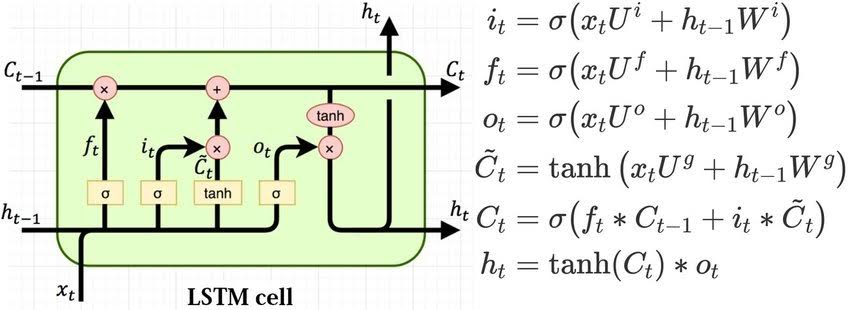

In [17]:
def train(EPOCH_NUM, BATCH_SIZE, LR, alpha, hid_state_size, hid_layer_size, out_size, T, X_train, X_val, y_train, y_val):
    print(f'Train for epoch:{EPOCH_NUM}, batch size:{BATCH_SIZE}, lr: {LR}')

    W, U, b = initialize_weights(3, hid_state_size, hid_layer_size, out_size) # initialize the weights

    # CSE records
    train_CSE = []
    val_CSE = []
    val_acc = []
    delta_prev = None # For momentum
    batch_num = int(np.ceil(X_train.shape[0] / BATCH_SIZE))
    h_init = np.zeros((1, hid_state_size))
    c_init = np.zeros((1, hid_state_size))
    
    patience = 3
    W_1 = None
    U_1 = None
    b_1 = None
    h_1 = None
    c_1 = None
    W_2 = None
    U_2 = None
    b_2 = None
    h_2 = None
    c_2 = None
    
    for epoch in range(EPOCH_NUM):
        if epoch > 0 and epoch % 1 == 0: # Report metrics
            # TODO
            train_accuracy = predict(X_train, y_train, T, h_init, c_init, W, U, b) # Counts true if the true word is in the top ten predictions
            val_accuracy = predict(X_val, y_val, T, h_init, c_init, W, U, b)
            print('Epoch:', epoch)
            print('Train CSE:', train_CSE[-1])
            print('Validation CSE:', val_CSE[-1])
            print('Train accuracy:', train_accuracy)
            print('Validation accuracy:', val_accuracy)
        # Shuffle dataset
        shuffled_X, shuffled_y = unison_shuffled_copies(X_train, y_train)

        totalCSE = 0

        beginning = 0

        for i in range(batch_num):
            if i < batch_num - 1:
                X = shuffled_X[beginning: beginning + BATCH_SIZE] 
                y = shuffled_y[beginning: beginning + BATCH_SIZE]
            else:
                X = shuffled_X[beginning: ] 
                y = shuffled_y[beginning: ]
            beginning += BATCH_SIZE
            
            # TODO
            ####### Calculate activations and errors ############
            H, C, I, F, O, C_, hidden, out = forward(X, h_init, c_init, W, U, b, T) # Forward pass
            totalCSE += calculate_errors(out, y) # Loss calculation
            #####################################################
            W_grad, U_grad, b_grad, h_grad, c_grad = backward(X, y, h_init, c_init, H, C, I, F, O, C_, hidden, out, W, U, b, T) # Backpropagation algorithm
            ##### Delta calculations for momentum ######
            delta_W_c = -1 * LR * W_grad['c']
            delta_W_i = -1 * LR * W_grad['i']
            delta_W_f = -1 * LR * W_grad['f']
            delta_W_o = -1 * LR * W_grad['o']
            delta_U_c = -1 * LR * U_grad['c']
            delta_U_i = -1 * LR * U_grad['i']
            delta_U_f = -1 * LR * U_grad['f']
            delta_U_o = -1 * LR * U_grad['o']
            delta_b_c = -1 * LR * b_grad['c']
            delta_b_i = -1 * LR * b_grad['i']
            delta_b_f = -1 * LR * b_grad['f']
            delta_b_o = -1 * LR * b_grad['o']
            delta_W_1 = -1 * LR * W_grad['1']
            delta_b_1 = -1 * LR * b_grad['1']
            delta_W_2 = -1 * LR * W_grad['2']
            delta_b_2 = -1 * LR * b_grad['2']
            delta_h = -1 * LR * h_grad
            delta_c = -1 * LR * c_grad
            
            if delta_prev != None:
                delta_W_c += alpha * delta_prev['W_c']
                delta_W_i += alpha * delta_prev['W_i']
                delta_W_f += alpha * delta_prev['W_f']
                delta_W_o += alpha * delta_prev['W_o']
                delta_U_c += alpha * delta_prev['U_c']
                delta_U_i += alpha * delta_prev['U_i']
                delta_U_f += alpha * delta_prev['U_f']
                delta_U_o += alpha * delta_prev['U_o']
                delta_b_c += alpha * delta_prev['b_c']
                delta_b_i += alpha * delta_prev['b_i']
                delta_b_f += alpha * delta_prev['b_f']
                delta_b_o += alpha * delta_prev['b_o']
                delta_W_1 += alpha * delta_prev['W_1']
                delta_W_2 += alpha * delta_prev['W_2']
                delta_b_1 += alpha * delta_prev['b_1']
                delta_b_2 += alpha * delta_prev['b_2']
                delta_h += alpha * delta_prev['h_init']
                delta_c += alpha * delta_prev['c_init']
            delta_prev = {'W_c': delta_W_c, 'W_i': delta_W_i, 'W_f': delta_W_f, 'W_o': delta_W_o, 'U_c': delta_U_c, 'U_i': delta_U_i, 'U_f': delta_U_f, 'U_o': delta_U_o, 'b_c': delta_b_c, 'b_i': delta_b_i, 'b_f': delta_b_f, 'b_o': delta_b_o, 'W_1': delta_W_1, 'W_2': delta_W_2, 'b_1': delta_b_1, 'b_2': delta_b_2, 'h_init': delta_h, 'c_init': delta_c}
            ###### Update weights ###############
            W_2 = W_1
            U_2 = U_1
            b_2 = b_1
            h_2 = h_1
            c_2 = c_1
            W_1 = W
            U_1 = U
            b_1 = b
            h_1 = h_init
            c_1 = c_init
            W['c'] += delta_W_c
            W['i'] += delta_W_i
            W['f'] += delta_W_f
            W['o'] += delta_W_o
            U['c'] += delta_U_c
            U['i'] += delta_U_i
            U['f'] += delta_U_f
            U['o'] += delta_U_o
            b['c'] += delta_b_c
            b['i'] += delta_b_i
            b['f'] += delta_b_f
            b['o'] += delta_b_o
            W['1'] += delta_W_1
            W['2'] += delta_W_2
            b['1'] += delta_b_1
            b['2'] += delta_b_2
            h_init += delta_h
            c_init += delta_c
            #####################################

        train_CSE.append(totalCSE / X_train.shape[0])
        H, C, I, F, O, C_, hidden, out = forward(X_val, h_init, c_init, W, U, b, T) # Forward pass
        val_CSE.append(calculate_errors(out, y_val) / X_val.shape[0])
        val_acc.append(predict(X_val, y_val, T, h_init, c_init, W, U, b))
        if len(val_CSE) > 1: # Early stopping if validation loss starts to increase or it is stationary
            if val_CSE[-1] > val_CSE[-2]:
                if patience == 1:
                    print('Finished at epoch', epoch)
                    return train_CSE, val_CSE, val_acc, W_2, U_2, b_2, h_2, c_2
                else:
                    W_last = W
                    patience -= 1
            else:
                patience = 3

    return train_CSE, val_CSE, val_acc, W, U, b, h_init, c_init

In [12]:
results_val = {}

In [18]:
EPOCH_NUM = 50
BATCH_SIZE = 32
hid_state_size = 128
out_size = 6
T = 150

LR_arr = [0.1]#, 0.01, 0.1]
hid_layer_size_arr = [64]#, 256]
alpha_arr = [0.85]#, 0.50 ,0.85]

#results_train = {}
#results_val = {}
for LR in LR_arr:
    for hid_layer_size in hid_layer_size_arr:
        for alpha in alpha_arr:
            result = train(EPOCH_NUM, BATCH_SIZE, LR, alpha, hid_state_size, hid_layer_size, out_size, T, X_train, X_val, y_train, y_val)
            #results_train[f'{LR}-{hid_layer_size}-{alpha}'] = a
            #results_val[f'{LR}-{hid_layer_size}-{alpha}'] = c

Train for epoch:50, batch size:32, lr: 0.1
Epoch: 1
Train CSE: 1.662513019820879
Validation CSE: 1.5968113416942558
Train accuracy: 0.29555555555555557
Validation accuracy: 0.27666666666666667
Epoch: 2
Train CSE: 1.5373642785111459
Validation CSE: 1.5070250144794708
Train accuracy: 0.3011111111111111
Validation accuracy: 0.30666666666666664
Epoch: 3
Train CSE: 1.4899807844436197
Validation CSE: 1.4780977914065696
Train accuracy: 0.3148148148148148
Validation accuracy: 0.3433333333333333
Epoch: 4
Train CSE: 1.4447399225700794
Validation CSE: 1.427019350704983
Train accuracy: 0.3385185185185185
Validation accuracy: 0.35
Epoch: 5
Train CSE: 1.3970185950464562
Validation CSE: 1.4544284597721442
Train accuracy: 0.4088888888888889
Validation accuracy: 0.3933333333333333
Epoch: 6
Train CSE: 1.3842676036445316
Validation CSE: 1.38199415906717
Train accuracy: 0.4411111111111111
Validation accuracy: 0.42333333333333334
Epoch: 7
Train CSE: 1.3659810425513272
Validation CSE: 1.393250277422759
Trai

In [18]:
for key in results_val.keys():
    print(key)
    print(max(results_val[key]))
    print('\n\n')

0.007-64-0.85
0.5666666666666667





In [20]:
len(result[0])

38

In [21]:
import joblib
joblib.dump(result, 'lstm_best.joblib')

['lstm_best.joblib']

In [22]:
def plot_graph(funcs, labels, title, xlabel, ylabel):
    colors = ['black', 'blue', 'red', 'green']
    min_epoch = 50
    for func in funcs:
        if len(func) < min_epoch:
            min_epoch = len(func)
    for i, func in enumerate(funcs):
        plt.plot(range(min_epoch), func[:min_epoch], color=colors[i], label=labels[i])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.show()

In [28]:
def confusion_matrix(X, y, T, h_init, c_init, W, U, b): # Counts true if the true word is in the top ten predictions
    H, C, I, F, O, C_, hidden, outputs = forward(X, h_init, c_init, W, U, b, T)
    correct = np.argmax(y, axis=1)
    predictions = np.argmax(outputs, axis=1)
    conf_matrix = np.zeros((6,6))
    for i, prediction in enumerate(predictions):
        conf_matrix[prediction, correct[i]] += 1
    #print('Confusion matrix:\n')
    #print(conf_matrix)
    return conf_matrix, np.sum(correct == predictions) / y.shape[0]

In [26]:
plot_graph([result[1]], ['Validation error'], 'Validation CSE over Epochs', 'Epoch', 'CSE Error')

In [31]:
cm,acc = confusion_matrix(X_test, y_test, 150, result[6], result[7], result[3], result[4], result[5])
print(acc)

0.4716666666666667


In [32]:
print(cm)

[[22. 12.  1.  1. 21. 24.]
 [ 0. 32.  1.  0.  1.  4.]
 [ 0.  2. 98.  0.  0.  0.]
 [37.  2.  0. 78. 35. 16.]
 [17.  6.  0.  3. 10. 13.]
 [24. 46.  0. 18. 33. 43.]]


In [24]:
def check(EPOCH_NUM, BATCH_SIZE, LR, alpha, hid_state_size, hid_layer_size, out_size, T, X_train, X_val, y_train, y_val):
    W, U, b = initialize_weights(3, hid_state_size, hid_layer_size, out_size) # initialize the weights
    h_init = np.random.uniform(low=-6, high=6, size=(1, hid_state_size))
    c_init = np.random.uniform(low=-6, high=6, size=(1, hid_state_size))
    
    X = X_train[:32]
    y = y_train[:32]
    epsilon = 0.0000001
    
    W_epsilon = {}
    b_epsilon = {}
    b_plus = {}
    W_plus = {}
    U_epsilon = {}
    U_plus = {}
    
    for key in W.keys():
        #print(key)
        W_epsilon[key] = W[key]
        W_plus[key] = W[key]
    for key in U.keys():
        U_epsilon[key] = U[key]
        U_plus[key] = U[key]
    for key in b.keys():
        b_epsilon[key] = b[key]
        b_plus[key] = b[key]
        
    h_epsilon = h_init# - epsilon
    h_plus = h_init# + epsilon
    c_epsilon = c_init# - epsilon
    c_plus = c_init# + epsilon
    #print(c_epsilon)
    #print(c_plus)
    #print(c_init)
    #print(np.sum(W['1']))
    cur_key = '2'
    b_epsilon[cur_key] = b_epsilon[cur_key] - epsilon
    b_plus[cur_key]= b_plus[cur_key] + epsilon
    #print(epsilon)
    #print(np.sum(W_epsilon['1']), np.sum(W_plus['1']), np.sum(W['1']))
    H, C, I, F, O, C_, hidden, out = forward(X, h_epsilon, c_epsilon, W_epsilon, U_epsilon, b_epsilon, T) # Forward pass
    J_1 = calculate_errors(out, y) # Loss calculation
    H, C, I, F, O, C_, hidden, out = forward(X, h_plus, c_plus, W_plus, U_plus, b_plus, T) # Forward pass
    J_2 = calculate_errors(out, y) # Loss calculation
    H, C, I, F, O, C_, hidden, out = forward(X, h_init, c_init, W, U, b, T) # Forward pass
    W_grad, U_grad, b_grad, h_grad, c_grad = backward(X, y, h_init, c_init, H, C, I, F, O, C_, hidden, out, W, U, b, T) # Backpropagation algorithm
    expected = np.sum(b_grad[cur_key])
    real = (J_2/32 - J_1/32)/(2*epsilon)
    print((real-expected)/(real+expected))
    print(real)
    print(expected)

check(EPOCH_NUM, BATCH_SIZE, LR, alpha, hid_state_size, hid_layer_size, out_size,T, X_train, X_val, y_train, y_val)

-1.0
0.0
3.469446951953614e-17


In [6]:
EPOCH_NUM = 100
BATCH_SIZE = 32
hid_state_size = 128
out_size = 6
T = 150

LR = 0.01
hid_layer_size = 16 #16, 32, 64, 128, 256]
alpha = 0#, 0.50 ,0.85]


check(EPOCH_NUM, BATCH_SIZE, LR, alpha, hid_state_size, hid_layer_size, out_size, T, X_train, X_val, y_train, y_val)

NameError: name 'modified_backward' is not defined

In [56]:
calculate_errors(np.array([[0.2, 0.5, 0.1, 0.2],[0.4,0.3,0.2, 0.1],[0.56,0.12,0.32, 0.1],[0.35,0.25,0.3, 0.1]]), y_train[:4,:4])

6.684611727667927

In [57]:
np.log(0.5*0.1*0.1*0.25)

-6.684611727667927

In [54]:
y_train[:4, :4]

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.]])

In [ ]:
o = np.array([[0.2, 0.5, 0.1, 0.2],[0.4,0.3,0.2, 0.1],[0.56,0.12,0.32, 0.1],[0.35,0.25,0.3, 0.1]])
d = y_train[:4,:4]
target_predictions = np.multiply(o, d) # Only target class probs
target_predictions = np.sum(target_predictions, axis=1) 
-1 * np.sum(np.log(target_predictions)) # -yi.log(pi)